#### City of San Diego - Data SD
* Dataset name: Monitoring of Indicator Bacteria in Drinking Water
* URL: https://data.sandiego.gov/datasets/monitoring-of-indicator-bacteria-in-drinking-water/

In [19]:
import pandas as pd
import numpy as np

import datetime
from dateutil import parser # to validate if string values are dates

import warnings 
warnings.filterwarnings(action= 'ignore')

#### Analyze the data frame

In [20]:
def dataframe_columns(df):

    print('Shape: ', df.shape)

    columns_value_counts = []

    for cols in (df.columns):
        columns_value_counts.append({'column': cols,
        'dtype': df[cols].dtypes,
        'null_total': df[cols].isnull().sum(),
        'null_pct': round(df[cols].isnull().sum() / df.shape[0] * 100, 2),
        'unique_values_total': df[cols].nunique(),
        'max_unique_value': df[cols].astype(str).value_counts().to_frame().head(1).reset_index()['index'][0],
        'max_unique_value_total': df[cols].astype(str).value_counts().to_frame().head(1).reset_index(drop=True)[cols].values[0],
        'max_unique_value_pct': round(df[cols].astype(str).value_counts().to_frame().head(1).reset_index(drop=True)[cols].values[0] / df.shape[0] * 100, 2)})

    return pd.DataFrame(columns_value_counts)

#### Import data

In [21]:
print('''"pH: potential of hydrogen. pH is a measure of how acidic or basic water is. 
The range goes from 0 - 14, with 7 being neutral. pHs of less than 7 indicate acidity, 
whereas pHs greater than 7 are basic (The City of San Diego, 2022, p.8).
''')

print('''References: 
The City of San Diego. (2022). The City of San Diego Annual Drinking Water Quality Report 2022. https://www.sandiego.gov/sites/default/files/hyperlink_wqr_2022.pdf''')


# Data Dictionary provided by source
dict_df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_dictionary_datasd.csv').fillna('')


print('''
pH categories:
      Neutral = 7
      Acidity < 7
      Basic   > 7
''')


dict_df

"pH: potential of hydrogen. pH is a measure of how acidic or basic water is. 
The range goes from 0 - 14, with 7 being neutral. pHs of less than 7 indicate acidity, 
whereas pHs greater than 7 are basic (The City of San Diego, 2022, p.8).

References: 
The City of San Diego. (2022). The City of San Diego Annual Drinking Water Quality Report 2022. https://www.sandiego.gov/sites/default/files/hyperlink_wqr_2022.pdf

pH categories:
      Neutral = 7
      Acidity < 7
      Basic   > 7



,Field,Description,Possible values
0,sample_date,Date sample was taken,
1,site_ID,Unique identifier for the sample site,
2,temp_celsius,Temperature in Celsius,
3,chlorine,Chlorine in mg/l or ppm,
4,pH,pH of water sample,0-14
5,coliform,Presence of Coliform indicator bacteria,"A-Absent, P-Present"
6,E.coli,Presence of E.coli indicator bacteria,"A-Absent, P-Present"


In [110]:
# All Drinking Water Tests(Bacteria)
df = pd.read_csv('https://seshat.datasd.org/water_testing/indicator_bacteria_tests_datasd_v1.csv')

In [23]:
# account for ph categories
df['ph_cat'] = np.where(df.ph == 7, 'Neutral=7',
                 np.where(df.ph < 7, 'Acidity<7',
                   np.where(df.ph > 7, 'Basic>7', 'Missing')))

#### Check dataframe #1

In [24]:
dataframe_columns(df)

Shape:  (85095, 10)


,column,dtype,null_total,null_pct,unique_values_total,max_unique_value,max_unique_value_total,max_unique_value_pct
0,FR_NUM,int64,0,0.00,62122,404447,16,0.02
1,date_sampled,object,0,0.00,1971,2020-01-02,155,0.18
2,source,object,0,0.00,156,307 SYS,2382,2.80
3,sample_id,object,0,0.00,62122,W1598494,16,0.02
4,t_coliform,object,69,0.08,3,A,84792,99.64
5,cl2_total,float64,0,0.00,364,2.5,2447,2.88
6,e_coli,object,58,0.07,2,A,84919,99.79
7,temperature,float64,0,0.00,222,17.4,911,1.07
8,ph,float64,0,0.00,159,8.11,2501,2.94
9,ph_cat,object,0,0.00,3,Basic>7,85073,99.97


##### FR_NUM and source analysis

In [27]:
# load sample_id value counts into dictionary
sample_id_dict = dict(df.sample_id.value_counts())

# identify sample_id values with multiple rows, and place their value into a list
sample_id_duplicates_list = []

for v, k in sample_id_dict.items():
    """ Only return sample_id values that are represented in multiple rows"""
    if k > 1:
        sample_id_duplicates_list.append(v)

# shape of rows containing duplicate sample_id values
pd.DataFrame(sample_id_duplicates_list).shape

(2745, 1)

In [54]:
for si in (pd.DataFrame(sample_id_duplicates_list)[0].sample(1)):
    sample_id_var = si

print('''Querying the sample_id values identified to have multiple rows, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.''')

df.query("sample_id == @sample_id_var").drop_duplicates()

Querying the sample_id values identified to have multiple rows, shows that FR_NUM, date_sampled, source, 
sample_id, t_coliform, and e_coli are the same values for these multiple rows; however, 
cl2_total, temperature, and ph have similar values but not the same.


,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,ph_cat
33931,327146,2019-03-18,327 SYS,W1294785,A,1.67,A,16.2,8.01,Basic>7
33932,327146,2019-03-18,327 SYS,W1294785,A,1.67,A,16.2,8.03,Basic>7
33933,327146,2019-03-18,327 SYS,W1294785,A,1.67,A,16.3,8.01,Basic>7
33934,327146,2019-03-18,327 SYS,W1294785,A,1.67,A,16.3,8.03,Basic>7
33939,327146,2019-03-18,327 SYS,W1294785,A,1.68,A,16.2,8.01,Basic>7
33940,327146,2019-03-18,327 SYS,W1294785,A,1.68,A,16.2,8.03,Basic>7
33941,327146,2019-03-18,327 SYS,W1294785,A,1.68,A,16.3,8.01,Basic>7
33942,327146,2019-03-18,327 SYS,W1294785,A,1.68,A,16.3,8.03,Basic>7


In [55]:
# Create dataframe from value_counts to identify columns that can be updated, as they appear to be duplicates
df2 = df[['FR_NUM', 'date_sampled', 'source', 'sample_id']].value_counts().to_frame(name='Counts')

df2 = df2.reset_index() # places "Counts" into the header row with all other columns

# Only keep columns with Counts greater than 1
df2 = df2.query("Counts > 1")

# Merge values from original dataframe, to get averages for these rows requiring averages for duplicate rows
df2 = df2.merge(df, left_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), right_on=('FR_NUM', 'date_sampled', 'source', 'sample_id'), how="inner")

In [56]:
# Itirate through sample_id values with multiply rows to get averages from their means for:
# cl2_total, temperature, and ph

df2_means = []

for si in (set(sample_id_duplicates_list)):

    df2_means.append({'sample_id': si,
                      'cl2_total_mean': round(df.query("sample_id == @si").cl2_total.mean(),1),
                      'temperature_mean': round(df.query("sample_id == @si").temperature.mean(),1),
                      'ph_mean': round(df.query("sample_id == @si").ph.mean(),1),
                      'sample_id_duplicate': 1})

In [57]:
# Merge average values into original dataframe
# The use of "left" join in the merge statement above, leaves non-duplicate values empty
# ensuring no loss of data
df = df.merge(pd.DataFrame(df2_means), left_on=('sample_id'), right_on=('sample_id'), how="left")

In [58]:
# Make updates to duplicate sample_id respective features with their means
# in the fillna statements below:
df['cl2_total'] = np.where(df.cl2_total_mean.fillna("") != "", df.cl2_total_mean, df.cl2_total)
df['temperature'] = np.where(df.temperature_mean.fillna("") != "", df.temperature_mean, df.temperature)
df['ph'] = np.where(df.ph_mean.fillna("") != "", df.ph_mean, df.ph)

In [68]:
# With all variations gone, we can now drop duplicates.
df.drop_duplicates(inplace=True)

In [60]:
# Review of sample_id referenced, to confirm single row returned with mean values
df.query("sample_id == @sample_id_var")

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,ph_cat,cl2_total_mean,temperature_mean,ph_mean,sample_id_duplicate
33931,327146,2019-03-18,327 SYS,W1294785,A,1.7,A,16.2,8.0,Basic>7,1.7,16.2,8.0,1.0


In [61]:
# Drop unnecessary columns for remainder of the process - used in previous steps
df.drop(['cl2_total_mean', 'temperature_mean', 'ph_mean'], axis=1, inplace=True)

In [62]:
# update sample_id_duplicate values to account for missing and convert from float to int
df.sample_id_duplicate = df.sample_id_duplicate.fillna(0).astype(int)

#### Check dataframe #2

In [69]:
dataframe_columns(df)

Shape:  (62122, 11)


,column,dtype,null_total,null_pct,unique_values_total,max_unique_value,max_unique_value_total,max_unique_value_pct
0,FR_NUM,int64,0,0.00,62122,244324,1,0.00
1,date_sampled,object,0,0.00,1971,2020-01-02,87,0.14
2,source,object,0,0.00,156,222A SYS,493,0.79
3,sample_id,object,0,0.00,62122,W983115,1,0.00
4,t_coliform,object,52,0.08,3,A,61872,99.60
5,cl2_total,float64,0,0.00,364,2.4,2239,3.60
6,e_coli,object,41,0.07,2,A,61979,99.77
7,temperature,float64,0,0.00,218,17.0,626,1.01
8,ph,float64,0,0.00,158,8.1,2428,3.91
9,ph_cat,object,0,0.00,3,Basic>7,62110,99.98


In [70]:
df[(df.FR_NUM == 397686) == True]

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,ph_cat,sample_id_duplicate
81009,397686,2023-04-24,268 SYS,W1567987,A,5.7,A,22.8,5.7,Acidity<7,1


In [66]:
# re-calibrate ph categories
df['ph_cat'] = np.where(df.ph == 7, 'Neutral=7',
                 np.where(df.ph < 7, 'Acidity<7',
                   np.where(df.ph > 7, 'Basic>7', 'Missing')))

##### Validate 'date' field(s) that are set to 'object' type

In [81]:
invalid_date_list = []

date_cursor = 0

for d in(df.date_sampled):
    try:
        bool(parser.parse(d))
        date_cursor += 0
    except ValueError:
        invalid_date_list.append({'Invalid Date': d})
        date_cursor += 1

# print results from above validation
if date_cursor == 0:
    print('All dates are valid')
else:
    print(pd.DataFrame(invalid_date_list).drop_duplicates())

All dates are valid


##### Update date(s) field(s) to date time (if all date strings are valid dates)

In [82]:
df.date_sampled = pd.to_datetime(df.date_sampled)

#### Re-sort the data -- Determine what elements to account for before sorting data by date

In [83]:
df.date_sampled.describe()

count                   62122
unique                   1971
top       2020-01-02 00:00:00
freq                       87
first     2014-06-02 00:00:00
last      2023-09-05 00:00:00
Name: date_sampled, dtype: object

In [84]:
df.FR_NUM.describe()

count     62122.000000
mean     324094.585799
std       46330.002926
min      244324.000000
25%      283343.250000
50%      324416.500000
75%      364137.750000
max      404447.000000
Name: FR_NUM, dtype: float64

In [85]:
# When considering FR_NUM in the sort criteria, the first FR_NUM reflected does not match the min from the describe above
df[['date_sampled', 'FR_NUM']].sort_values(by=['date_sampled', 'FR_NUM'], ascending=True).head(10)

,date_sampled,FR_NUM
66,2014-06-02,244446
67,2014-06-02,244447
68,2014-06-02,244448
69,2014-06-02,244449
70,2014-06-02,244450
71,2014-06-02,244451
72,2014-06-02,244453
73,2014-06-02,244454
74,2014-06-02,244456
75,2014-06-02,244457


In [86]:
# When checking the FR_NUM.min() value, it aligns with a date not equal to the first date in the date series
df[(df.FR_NUM == df.FR_NUM.min()) == True]

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,ph_cat,sample_id_duplicate
0,244324,2014-06-05,244 SYS,W983115,A,1.91,A,23.4,8.02,Basic>7,0


In [87]:
# When considering sample_id in the sort criteria, the first date_sampled reflected does not match the min from the sample_id
min_sample_id = 'W' + str(df.sample_id.str.replace('W','').astype(int).min())

print('min sample_id:   ',  min_sample_id)

df[['date_sampled', 'sample_id']].sort_values(by=['date_sampled', 'sample_id'], ascending=True).head(10)

min sample_id:    W983115


,date_sampled,sample_id
66,2014-06-02,W983396
67,2014-06-02,W983397
68,2014-06-02,W983398
69,2014-06-02,W983399
70,2014-06-02,W983400
71,2014-06-02,W983401
72,2014-06-02,W983404
73,2014-06-02,W983405
74,2014-06-02,W983407
75,2014-06-02,W983408


In [88]:
# the sample_id min(), also does not align with the first date in the series
df[(df.sample_id == min_sample_id) == True]

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,ph_cat,sample_id_duplicate
0,244324,2014-06-05,244 SYS,W983115,A,1.91,A,23.4,8.02,Basic>7,0


#### Re-sort data only by 'date_sampled' and reset index

In [89]:
df = df.sort_values(by=['date_sampled'], ascending=True).reset_index(drop=True)

#### Check dataframe #3

In [90]:
dataframe_columns(df)

Shape:  (62122, 11)


,column,dtype,null_total,null_pct,unique_values_total,max_unique_value,max_unique_value_total,max_unique_value_pct
0,FR_NUM,int64,0,0.00,62122,244479,1,0.00
1,date_sampled,datetime64[ns],0,0.00,1971,2020-01-02,87,0.14
2,source,object,0,0.00,156,222A SYS,493,0.79
3,sample_id,object,0,0.00,62122,W983434,1,0.00
4,t_coliform,object,52,0.08,3,A,61872,99.60
5,cl2_total,float64,0,0.00,364,2.4,2239,3.60
6,e_coli,object,41,0.07,2,A,61979,99.77
7,temperature,float64,0,0.00,218,17.0,626,1.01
8,ph,float64,0,0.00,158,8.1,2428,3.91
9,ph_cat,object,0,0.00,3,Basic>7,62110,99.98


#### Evaluate observations missing data (t_coliform)

In [94]:
# from data dictionary
dict_df[(dict_df.Field == 'coliform') == True]

,Field,Description,Possible values
5,coliform,Presence of Coliform indicator bacteria,"A-Absent, P-Present"


In [91]:
# per the data dictionary, only values 'A' and 'P' are valid
df.t_coliform.fillna('missing').value_counts()

A          61872
P            107
<             91
missing       52
Name: t_coliform, dtype: int64

In [95]:
# convert missing values to the string 'missing'
df.t_coliform.fillna('missing', inplace=True)

In [96]:
# confirm that invalid values appear
df.query("t_coliform != 'A' and t_coliform != 'P'").t_coliform.value_counts()

<          91
missing    52
Name: t_coliform, dtype: int64

#### Evaluate observations missing data (e_coli)

In [98]:
# from data dictionary
dict_df[(dict_df.Field == 'E.coli') == True]

,Field,Description,Possible values
6,E.coli,Presence of E.coli indicator bacteria,"A-Absent, P-Present"


In [99]:
# per the data dictionary, only values 'A' and 'P' are valid
df.e_coli.fillna('missing').value_counts()

A          61979
<            102
missing       41
Name: e_coli, dtype: int64

In [100]:
# convert missing values to the string 'missing'
df.e_coli.fillna('missing', inplace=True)

In [101]:
df.e_coli.value_counts()

A          61979
<            102
missing       41
Name: e_coli, dtype: int64

##### Evaluate both observations with missing values

In [104]:
# based on the analysis below, both observations have matching invalid values
# dropping invalid values from one of these fields will account for the other
df[['t_coliform', 'e_coli']].value_counts().to_frame(name='Combination Totals')

Combination Totals
t_coliform e_coli                     
A          A                     61872
P          A                       107
<          <                        91
missing    missing                  41
           <                        11

In [105]:
# drop respective invalid rows by their index
for ix in (df.query("t_coliform != 'A' and t_coliform != 'P'").index):
    df.drop(index= ix, inplace=True)

#### Dataframe check #4

In [106]:
dataframe_columns(df)

Shape:  (61979, 11)


,column,dtype,null_total,null_pct,unique_values_total,max_unique_value,max_unique_value_total,max_unique_value_pct
0,FR_NUM,int64,0,0.0,61979,244479,1,0.00
1,date_sampled,datetime64[ns],0,0.0,1937,2020-01-02,87,0.14
2,source,object,0,0.0,156,317 SYS,485,0.78
3,sample_id,object,0,0.0,61979,W983434,1,0.00
4,t_coliform,object,0,0.0,2,A,61872,99.83
5,cl2_total,float64,0,0.0,364,2.4,2238,3.61
6,e_coli,object,0,0.0,1,A,61979,100.00
7,temperature,float64,0,0.0,217,17.0,626,1.01
8,ph,float64,0,0.0,158,8.1,2422,3.91
9,ph_cat,object,0,0.0,3,Basic>7,61967,99.98


In [113]:
print('''Public Utilities currently has 160 sample sites for the City of San Diego drinking water system and is required to test 85 sites per week. 
Temperature, chlorine and pH are measured on site, and then a sample is brought to a lab to test for the presence of the indicator bacteria coliform and E.coli. 
Coliform and the strains of E.coli tested serve as indicators of the presence of potentially harmful bacteria.''')

print('\n', 'Total number of potential sample sites in data set:  ', df.source.value_counts().to_frame(name='Totals').shape[0])

print('\n', 'Question: Why are there 4 missing sample sites in the data set?')

Public Utilities currently has 160 sample sites for the City of San Diego drinking water system and is required to test 85 sites per week. 
Temperature, chlorine and pH are measured on site, and then a sample is brought to a lab to test for the presence of the indicator bacteria coliform and E.coli. 
Coliform and the strains of E.coli tested serve as indicators of the presence of potentially harmful bacteria.

 Total number of potential sample sites in data set:   156

 Question: Why are there 4 missing sample sites in the data set?


#### Year and Week feature to determine if 85 sites are being tested per week

In [115]:
week_number = []

# convert datetime to object to obtain its isocalendar value (week number)
for d in (df.date_sampled.astype(str)):
    week_number.append({'week_number': datetime.datetime.strptime(d, '%Y-%m-%d').isocalendar()[1]})

In [116]:
# merge week_number values into main data frame, merging on index
df = df.merge(pd.DataFrame(week_number), on=df.index)

In [117]:
# drop new column created by merge
df.drop(columns={'key_0'}, inplace=True)

In [118]:
# create new feature for year and week number
df['year_week'] = df.date_sampled.astype(str).str[:4] + '-' + df.week_number.astype(str)

In [119]:
test_site_counter = 0

for k, v in (dict(df.year_week.value_counts()).items()):
    if v <= 85:
        test_site_counter += 1
        print('year_week:  ' + str(k) + '     test count:  ' + str(v))

if test_site_counter == 0:
    print('At least 85 sites are being tested per week')

At least 85 sites are being tested per week


In [136]:
# add year_week value count to data frame
year_week_df = df.year_week.value_counts().to_frame(name='year_week_total').reset_index()

# rename columns
year_week_df.rename(columns={'index': 'year_week'}, inplace=True)

# sample of year_week_df
year_week_df.sample(3)

,year_week,year_week_total
81,2020-28,135
355,2020-30,123
341,2017-19,123


In [143]:
# merge year_week_total into main dataframe
df = df.merge(year_week_df, left_on='year_week', right_on='year_week', how='inner')

##### Dataframe check #5

In [144]:
dataframe_columns(df)

Shape:  (61979, 14)


,column,dtype,null_total,null_pct,unique_values_total,max_unique_value,max_unique_value_total,max_unique_value_pct
0,FR_NUM,int64,0,0.0,61979,244479,1,0.00
1,date_sampled,datetime64[ns],0,0.0,1937,2020-01-02,87,0.14
2,source,object,0,0.0,156,317 SYS,485,0.78
3,sample_id,object,0,0.0,61979,W983434,1,0.00
4,t_coliform,object,0,0.0,2,A,61872,99.83
5,cl2_total,float64,0,0.0,364,2.4,2238,3.61
6,e_coli,object,0,0.0,1,A,61979,100.00
7,temperature,float64,0,0.0,217,17.0,626,1.01
8,ph,float64,0,0.0,158,8.1,2422,3.91
9,ph_cat,object,0,0.0,3,Basic>7,61967,99.98


##### describe values for year_week values

In [148]:
df.year_week.value_counts().describe()

count    483.000000
mean     128.320911
std        6.991290
min       87.000000
25%      123.000000
50%      126.000000
75%      134.000000
max      163.000000
Name: year_week, dtype: float64

<Axes: ylabel='Frequency'>

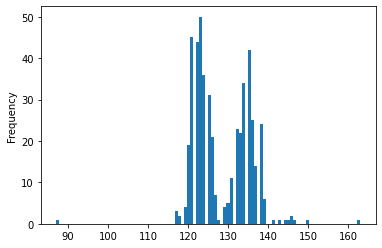

In [147]:
df.year_week.value_counts().plot(kind='hist', bins=100)

In [168]:
# add source_totals to data frame
source_totals_df = df.source.value_counts().to_frame(name='source_totals').reset_index()

# rename column
source_totals_df.rename(columns={'index': 'source'}, inplace=True)

# sample
source_totals_df.sample(3)

,source,source_totals
51,315A SYS,483
105,222A SYS,480
135,253 SYS,111


In [169]:
# merge source_totals into main dataframe
df = df.merge(source_totals_df, left_on='source', right_on='source', how='inner')

##### Dataframe check #6

In [170]:
dataframe_columns(df)

Shape:  (61979, 15)


,column,dtype,null_total,null_pct,unique_values_total,max_unique_value,max_unique_value_total,max_unique_value_pct
0,FR_NUM,int64,0,0.0,61979,244479,1,0.00
1,date_sampled,datetime64[ns],0,0.0,1937,2020-01-02,87,0.14
2,source,object,0,0.0,156,317 SYS,485,0.78
3,sample_id,object,0,0.0,61979,W983434,1,0.00
4,t_coliform,object,0,0.0,2,A,61872,99.83
5,cl2_total,float64,0,0.0,364,2.4,2238,3.61
6,e_coli,object,0,0.0,1,A,61979,100.00
7,temperature,float64,0,0.0,217,17.0,626,1.01
8,ph,float64,0,0.0,158,8.1,2422,3.91
9,ph_cat,object,0,0.0,3,Basic>7,61967,99.98


In [173]:
# some sources have been tested much more times than others
df.source_totals.describe()

# question: Why is there a disproportionality in source_totals?

count    61979.000000
mean       457.017232
std         90.063243
min         67.000000
25%        481.000000
50%        483.000000
75%        484.000000
max        485.000000
Name: source_totals, dtype: float64

In [126]:
df.year_week.describe()

count       61979
unique        483
top       2020-18
freq          163
Name: year_week, dtype: object

In [174]:
df[(df.date_sampled == '2023-08-28') == True]

,FR_NUM,date_sampled,source,sample_id,t_coliform,cl2_total,e_coli,temperature,ph,ph_cat,sample_id_duplicate,week_number,year_week,year_week_total,source_totals
481,403887,2023-08-28,235 SYS,W1595970,A,2.60,A,26.4,8.13,Basic>7,0,35,2023-35,122,482
1560,403890,2023-08-28,234A SYS,W1595975,A,2.70,A,27.6,8.20,Basic>7,1,35,2023-35,122,483
2041,403885,2023-08-28,313 SYS,W1595966,A,0.23,A,25.6,8.00,Basic>7,0,35,2023-35,122,481
2524,403898,2023-08-28,262 SYS,W1595988,A,2.90,A,25.2,7.87,Basic>7,0,35,2023-35,122,483
4934,403899,2023-08-28,174 SYS,W1595989,A,2.70,A,24.8,7.68,Basic>7,0,35,2023-35,122,478
5373,403901,2023-08-28,242 SYS,W1595992,A,0.10,A,30.2,7.80,Basic>7,1,35,2023-35,122,439
5856,403902,2023-08-28,152A SYS,W1595993,A,0.72,A,27.9,7.91,Basic>7,0,35,2023-35,122,483
6341,403904,2023-08-28,281 SYS,W1595995,A,2.40,A,26.9,7.92,Basic>7,0,35,2023-35,122,485
6825,403905,2023-08-28,212 SYS,W1595996,A,2.60,A,28.7,7.91,Basic>7,0,35,2023-35,122,484
7285,403906,2023-08-28,210 SYS,W1595997,A,0.85,A,27.2,7.89,Basic>7,0,35,2023-35,122,460


#### ph describe analysis

In [ ]:
df.ph.describe()

In [ ]:
print('Only one record is returned having ph value greater or equal to 14')

df[(df.ph >= 14) == True]

In [ ]:
print('When querying the dataframe for ''like'' features for the result above, the same singleton result is returned')
df.query("t_coliform == 'A' and cl2_total == 0.8 and e_coli == 'A' and temperature == 8.0")

In [ ]:
print('We will remove the row from the data frame')

for ix in (df[(df.ph >= 14) == True].index):
    df.drop(index=ix, inplace=True)

In [ ]:
print('Check the describe results for ph to ensure the invalid ph value is no longer present')
df.ph.describe()

#### Dataframe check #7

In [ ]:
dataframe_columns(df)

#### ......this is where I left off

In [ ]:
#pd.DataFrame(df.dtypes).value_counts().to_frame(name='Counts').reset_index()
df.dtypes.value_counts()

In [ ]:
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as inf

In [ ]:
df.select_dtypes('float64').columns.to_frame(name='Columns').reset_index(drop=True)

In [ ]:
inf_x = df.select_dtypes('float64')

In [ ]:
pd.plotting.scatter_matrix(inf_x)

In [ ]:
inf_x = inf_x.dropna()

In [ ]:
inf_x = sm.add_constant(inf_x)

In [ ]:
pd.DataFrame(inf_x.values)[1].describe()

In [ ]:
[inf.variance_inflation_factor(inf_x.values, i)
 for i in range(inf_x.shape[1])]

### Kmeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_X = np.array(inf_x.iloc[:,[1,2,3]])

In [ ]:
plt.scatter(kmeans_X[:,0], kmeans_X[:,1], kmeans_X[:,2], label="True Position")
plt.show();

In [ ]:
kmeans = KMeans(n_clusters=2)

In [ ]:
kmeans.fit(kmeans_X)

In [ ]:
print(kmeans.cluster_centers_)

In [ ]:
print(kmeans.labels_)

In [ ]:
plt.scatter(kmeans_X[:,0], kmeans_X[:,1], kmeans_X[:,2], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], color='black')
plt.show();

# Show Cluster and Centroid information below graph
cluster_centroid_df = pd.DataFrame(kmeans.cluster_centers_).iloc[:,[1]].sort_values(by=[1], ascending=False).reset_index()
cluster_centroid_df.rename(columns={'index': 'Cluster', 1:'Centroid'}, inplace=True)
cluster_centroid_df.style.hide_index()

In [ ]:
# add cluster information to data frame
df = pd.concat([df, pd.DataFrame(kmeans.labels_)], axis=1)

In [ ]:
# rename new column
df.rename(columns={0:'Cluster'}, inplace=True)

In [ ]:
cluster_cols = []

for c in (set(df.Cluster)):
    for cols in range(df.query("Cluster == @c").select_dtypes('float64').shape[1]):
        #print(df.query("Cluster == @c").select_dtypes('float64').iloc[cols].mean())

        cluster_cols.append({'Cluster': c,
                             'Columns': df.query("Cluster == @c").select_dtypes('float64').iloc[:,[cols]].columns.values[0],
                             'Min': df.query("Cluster == @c").select_dtypes('float64').iloc[:,[cols]].min().values[0],
                             'Mean': df.query("Cluster == @c").select_dtypes('float64').iloc[:,[cols]].mean().values[0],
                             'Max': df.query("Cluster == @c").select_dtypes('float64').iloc[:,[cols]].max().values[0]})


pd.DataFrame(cluster_cols).style.hide_index().format(precision=2)
# https://stackoverflow.com/questions/70329242/pandas-styler-does-not-maintain-rounding/70330004#70330004

In [ ]:
df.Cluster.value_counts().plot(kind='bar', rot=0)

plt.title('Clusters Distribution')

plt.show();

for k, v in (dict(df.Cluster.value_counts()).items()):
    print('Cluster: ' + str(k) + '   Observations: ' + str(v) + '    Pct. of Total:  ' + str(v/len(df))[:-13]+' %')

In [ ]:
# convert all feature dtypes to 'object'
for k, v in (dict(df.dtypes).items()):
    if v != 'object': # or k != 'column_name' if you prefer to omit a column by name
        df[k] = df[k].astype('object')

In [ ]:
df.dtypes

In [ ]:
# total observations with missing information
nulls_df = df.isnull().sum().to_frame().reset_index()
nulls_df.columns=['Field', 'TotalNulls']

# total rows in data frame by field
field_totals_df = df.count().to_frame().reset_index()
field_totals_df.columns=['Field', 'RowsWithData']

# merge data together
nulls_df = nulls_df.query("TotalNulls != 0").merge(field_totals_df, left_on='Field', right_on='Field', how='inner')

# percentage of Null rows
nulls_df['PctNull'] = round(nulls_df.TotalNulls / nulls_df.RowsWithData,3)

# result
nulls_df.style.hide_index()

In [ ]:
# drop observations missing data and resulting shape
print('Original shape:                  ', df.shape)

df.dropna(inplace=True)
print('Shape after dropping null values:', df.shape)

In [ ]:
# final check for missing information
for n in (set(df.isnull().sum())):
    if n == 0:
        print('There is no more missing information')
    else:
        print('There is still missing information')

In [ ]:
# Value counts for t_coliform, to determine how to treat missing values
# the value '<' is being used, as it is included in data set, and being applied to missing values as well.
# According to data dictionary, only values A and P are valid
print(df.t_coliform.fillna("blank").value_counts())

# Values A and P are valid according to dictionary, "missing" and "<" values will be removed
# Update 't_coliform' with "<" so that it is easier to delete in next step
df['t_coliform'] = df.t_coliform.fillna("<")

# Since missing values and "<" are not in data dictionary; delete rows
df = df.query("t_coliform != '<'")
print("\n","df shape after dropping t_coliform invalid rows:")
print(df.shape)

# Missing values re-check
print("\n")
print(df.t_coliform.fillna("<").value_counts())

In [ ]:
# Data conversion
df['date_sampled'] =  pd.to_datetime(df.date_sampled)

In [ ]:
# if able to gain access to weather data, it would need to be between these date ranges
print('date_sampled min date:', df.date_sampled.min().strftime("%Y-%d-%m"))
print('date_sampled max date:', df.date_sampled.max().strftime("%Y-%d-%m"))

In [ ]:
print('''A value_counts for sample_id shows that there 
are multiple rows per sample_id:''')
df.sample_id.value_counts().head()

In [ ]:
# Based on the results from the above, it appears the data is ordered by date_sampled

# To ensure that all rows are following this pattern, the next step will 
# sort rows by date_sampled, source, and sample_id to get a chronological, to prepare for Time Series analysis

df.sort_values(['date_sampled', 'FR_NUM'], ascending=[True, True], inplace=True)

In [ ]:
# reset index, drop original index
df.reset_index(drop=True, inplace=True)

In [ ]:
# ph ranges, as defined in data dictionary section
df['ph_type'] = np.where(round(df.ph) == 7, 'ph_Neutral',
                np.where(round(df.ph) < 7, 'ph_Acidity',
                np.where(round(df.ph) > 7, 'ph_Basic', 'ph_Missing')))

# validate ph ranges to ph_types
ph_validation_df = df[['ph_type', 'ph']].value_counts().to_frame(name='Counts').reset_index()[['ph_type', 'ph']]
ph_validation_df['ph_round'] = round(ph_validation_df.ph)

pd.DataFrame(dict(ph_validation_df[['ph_type', 'ph_round']])).drop_duplicates().sort_values(by='ph_round').set_index('ph_round')

In [ ]:
# ph_type dummies
df = pd.concat([df,pd.get_dummies(df.ph_type)], axis=1)

# t_coliform dummies
df = pd.concat([df,pd.get_dummies(df.t_coliform)], axis=1)
df.rename(columns={'A':'t_coliform_A', 'P':'t_coliform_P'}, inplace=True)

print(df.shape)
df.sample(3)

In [ ]:
# Given that ph_Basic contains the majority of the information for ph types, the other two and ph_type will be dropped
df.ph_type.value_counts()

In [ ]:
# drop ph related columns as explained in chunk above
df.drop(columns=['ph_Neutral', 'ph_Acidity', 'ph_type'], inplace=True)

In [ ]:
# Given that t_coliform values of 'A' are dominant in the data set, t_coliform_P will be dropped, along with t_coliform
df.t_coliform.value_counts()

In [ ]:
# drop t_coliform related columns as explained in chunk above
df.drop(columns=['t_coliform_P', 't_coliform'], inplace=True)

In [ ]:
# given that all values in the e_coli feature are one single value, e_coli will be dropped from the data set,
# as its lack of variation, does not offer insight to the data set
df.e_coli.value_counts()

In [ ]:
# drop e_coli per explanation in chunk above
df.drop(columns=['e_coli'], inplace=True)

In [ ]:
df.sample(3)

#### Outliers


In [ ]:
# Outlier Analysis

# this function idea is from the Udemy "Feature Engineering for Machine Learning" course
def diagnostic_plots(df, variable, conversion):
    # function takes a dataframe and
    # the variable of interest

    # variable conversion
    if conversion == 'l':
        conv_var = np.log(df[variable])
        print('conversion: log')
    elif conversion == 's':
        conv_var = np.sqrt(df[variable])
        print('conversion: sqrt')
    elif conversion == 'c':
        conv_var = np.cbrt(df[variable])
        print('conversion: cbrt')
    elif conversion == 'a':
        conv_var = np.abs(df[variable])
        print('conversion: abs')
    else:
        conv_var = df[variable]
        print('conversion: none')    

    # define plot figure size
    plt.figure(figsize=(14,3))

    # histogram
    plt.subplot(1,3,1)
    sns.distplot(conv_var, bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1,3,2)
    stats.probplot(conv_var, dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=conv_var)
    plt.title('Boxplot')

    plt.show()

In [ ]:
# Function to find outliers by their respective high and low boundary, Gaussian distribution
# Got this idea from same Udemy video mentioned above
def find_normal_boundaries(df, variable, distance):

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return lower_boundary, upper_boundary

In [ ]:
# dictionary with conversion options
conversion_options = {'l': 'log', 's': 'sqrt', 'c': 'cbrt', 'a': 'abs'}

# print conversion options, key and values
for kv in (conversion_options.items()):
    print(kv)

#### cl2_total

In [ ]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'cl2_total', conversion_type)

In [ ]:
print('''The absolute value of cl2_total will be used as it has the best spread.
To address the outlier on the upper range, it will go through transformation in the next step''')

In [ ]:
# find lower and upper boundaries of 'cl2_total'
temperature_lower_limit, temperature_upper_limit = find_normal_boundaries(df, 'cl2_total', 3)

# Apply boundaries to outliers
df['cl2_total'] = np.where(df['cl2_total'] > temperature_upper_limit, temperature_upper_limit,
                     np.where(df['cl2_total'] < temperature_lower_limit, temperature_lower_limit,
                      df['cl2_total']))

In [ ]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'cl2_total', conversion_type)

In [ ]:
print('''After transformation, the cl2_total absolute value remains the best representation.
The outliers in the upper range were compressed, which in turn makes better use of its entire range.''')

#### temperature

In [ ]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'temperature', conversion_type)

In [ ]:
print(''' temperature will keep its absolute value and not go through transformation''')

#### ph

In [ ]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'ph', conversion_type)

In [ ]:
print('''cube root and square root conversions put the mean of the data in the middle.
The spread can benefit from adjusting its boundaries''')

In [ ]:
# find lower and upper boundaries of 'ph'
ph_lower_limit, ph_upper_limit = find_normal_boundaries(df, 'ph', 3)

# Apply boundaries to outliers
df['ph'] = np.where(df['ph'] > ph_upper_limit, ph_upper_limit,
                     np.where(df['ph'] < ph_lower_limit, ph_lower_limit,
                      df['ph']))

In [ ]:
for conversion_type in (set(conversion_options.keys())):
    diagnostic_plots(df, 'ph', conversion_type)

In [ ]:
print('''The boundaries modification benefitted the square root conversion best. 
It not only helped its horizontal range, but also compressed the frequency range.''')

In [ ]:
# conversion of ph to its square root
df.ph = np.sqrt(df.ph)

#### Scatter plots

In [ ]:
sns.pairplot(df.select_dtypes(include=['float64']))#, hue='yearMonth_t_coli_pct')
plt.show()

#### Correlation Matrix

In [ ]:
# Correlation Matrix
pearsoncorr = df.select_dtypes(include=['float64']).corr(method='pearson')

plt.figure(figsize= (5, 3))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)

In [ ]:
print('''
The float64 columns do not seem to have a relationship with one another, in the scatter plots; however,
the Correlation Matrix show a relationship between ph and cl2_total, at a value of 0.35. ''')

#### Time Series Analysis

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# add a feature for year from 'date_sampled' value
df['year'] = pd.DatetimeIndex(df.date_sampled).year

# add a feature for month from 'date_sampled' value
df['month'] = pd.DatetimeIndex(df.date_sampled).month

# add a feature to contain month and year
df['month_year'] = df.date_sampled.dt.to_period('M')

In [ ]:
df.sample(3)

#### cl2_total Time Series

In [ ]:
# load data
cl2_ts_df = df[['date_sampled', 'cl2_total']]

# set index to date
cl2_ts_df.set_index('date_sampled', inplace=True)

In [ ]:
cl2_seasonal_decompose = seasonal_decompose(x=cl2_ts_df['cl2_total'], period=2)

fig = cl2_seasonal_decompose.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

#### temperature Time Series

In [ ]:
# load data
temp_ts_df = df[['date_sampled', 'temperature']]

# set index to date
temp_ts_df.set_index('date_sampled', inplace=True)

In [ ]:
temp_seasonal_decompose = seasonal_decompose(x=temp_ts_df['temperature'], period=2)

fig = temp_seasonal_decompose.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

#### ph Time Series

In [ ]:
# load data
ph_ts_df = df[['date_sampled', 'ph']]

# set index to date
ph_ts_df.set_index('date_sampled', inplace=True)

In [ ]:
ph_seasonal_decompose = seasonal_decompose(x=ph_ts_df['ph'], period=2)

fig = ph_seasonal_decompose.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

#### Test and Train Data Split

In [ ]:
from sklearn.model_selection import train_test_split

#### Business purpose (from website)

* A positive result for coliform from one single test is not enough to constitute an MCL (Maximum Contaminant Level) violation. An acute violation occurs when a site that initially tested positive is repeat tested and either the initial sample or one of the repeat samples is positive for E. coli. A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. A positive coliform result from a single routine test may be due to sampling error or bacteria in the testing mechanism but not in the drinking water pipes.

In [ ]:
print('''There are no acute violations in the dataset, as all e_coli values equal 'A' 
across all {} rows, which is 'absent' e_coli.'''.format(pd.DataFrame(df.e_coli.value_counts()).iloc[0].values[0]))

df.e_coli.value_counts()

In [ ]:
print('''A monthly MCL violation occurs if more than 5 percent of all routine and repeat tests are coliform positive. 
We have 'P', present, values in the t_coliform feature.''',"\n")

df.t_coliform.value_counts()

#### Feature Engineering


In [ ]:
# Adding a month-year value to best identify MCL violations
df['year'] = pd.DatetimeIndex(df.date_sampled).year
df['month'] = pd.DatetimeIndex(df.date_sampled).month
df['yearMonth'] =  df.year.astype(str) + '-' + df.month.astype(str)

In [ ]:
# Identify yearMonth where t_coliform was Present, 'P'
ym_df = pd.DataFrame(df.query("t_coliform == 'P'").yearMonth.unique())
ym_df.columns = ['yearMonth']

# Get all data from df for yearMonth where there was t_coliform present
ym_df = df.merge(ym_df, left_on='yearMonth', right_on='yearMonth', how='inner')

In [ ]:
# Crosstab results, into dataframe
ym_df = pd.DataFrame(pd.crosstab(ym_df.yearMonth, ym_df.t_coliform)).reset_index()

# Add a Total column
ym_df['Total'] = ym_df.A + ym_df.P

# Add a t_coli percent column, representing the percentage of cases in the month, when t_coli was Present
ym_df['yearMonth_t_coli_pct'] = round(ym_df.P / ym_df.Total * 100)

In [ ]:
# Add yearMonth_t_coli_pct to main dataframe
df = df.merge(ym_df[['yearMonth', 'yearMonth_t_coli_pct']], left_on='yearMonth', right_on='yearMonth', how='left')

# Update Nan values to 0.0
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.fillna(0.0)


# Convert floats to integer
df['yearMonth_t_coli_pct'] = df.yearMonth_t_coli_pct.astype(int)

In [ ]:
print('''There are no t_coliform instances per Month, of more than 5% in the dataset.
When present, it has equaled as high as 1% for the respective month only.''',"\n")
df.yearMonth_t_coli_pct.value_counts()

### EDA


##### Subset

In [ ]:
df_subset = df[['date_sampled', 't_coliform', 'cl2_total', 'e_coli', 'temperature', 'ph', 'yearMonth_t_coli_pct']]

df_subset

##### Get dummies

In [ ]:
df_dummies = pd.get_dummies(df_subset.select_dtypes(include='object'))

# join uses index as default on join
df_subset = df_subset.join(df_dummies, how='outer')

# drop 'object' columns
df_subset.drop(columns=df_subset.select_dtypes(include='object').columns.tolist(), inplace=True)

df_subset

#### get dummies for year

In [ ]:
### get dummies for year

##### Target variable imbalance

In [ ]:
df_subset.yearMonth_t_coli_pct.value_counts().plot(kind='bar', rot=0)
plt.xlabel('Imbalance in yearMonth_t_coli_pct')
plt.show()

#### Balance target

In [ ]:
df_subset.yearMonth_t_coli_pct

##### Pairplot of numerical variables

In [ ]:
sns.pairplot(df_subset.select_dtypes(include=['float64', 'int64', 'int32']), hue='yearMonth_t_coli_pct')
plt.show()

### Create a Target classifier, representing a source that had t_coliform present at any point in the dataset.
### source_t_coliform_historically

In [ ]:
# Identify 'source' which has had t_coliform in the past
source_df = pd.DataFrame(df.query("t_coliform == 'P'").source.unique())
source_df.columns = ['source']
source_df['source_t_coliform_historically'] = 1

In [ ]:
# Merge source_df into main dataframe
df = df.merge(source_df, left_on='source', right_on='source', how='left')

# Convert missing values to 0
df['source_t_coliform_historically'] = df.source_t_coliform_historically.fillna(0)

# Convert to int
df['source_t_coliform_historically'] = df.source_t_coliform_historically.astype(int)

In [ ]:
# initiate sklearn LabelEncoder
le = preprocessing.LabelEncoder()

# LabelEncoder 'source' feature
le.fit(df['source'])
df['source_le'] =  le.transform(df['source'])

# LabelEncoder 'yearMonth' feature
le.fit(df['yearMonth'])
df['yearMonth_le'] =  le.transform(df['yearMonth'])

In [ ]:
# Binary values for t_coliform
df['t_coliform_bin'] = np.where(df.t_coliform == 'A', 0, 1)

## Proposed target variable

In [ ]:
# More than half of the "sources" have had t_coliform present at some point
pd.DataFrame(df.source_t_coliform_historically.value_counts()).plot.bar(rot=0, stacked=True, figsize=(10,7))

In [ ]:
print('''This graph shows ticks for the year when a label encoded source, had t_coliform present,
between the years 2015 through 2018. This is in effort to try and recognize patterns of recurring 
t_coliform at specific sources during this stretch of time.''',"\n")

sns.catplot(data=df.query("t_coliform_bin == 1 and year <= 2018 and year >= 2015"), x='year', y='source_le', s=10, height=8.27, aspect=11.7/8.27)
sns.set_style("ticks",{'axes.grid' : True})

In [ ]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (10, 7))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)